# Applied Plotting, Charting & Data Representation in Python -- Plotting Extreme Temperature Data


An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import mplleaflet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import datetime as dt
# import time as tm

In [2]:
def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize = (8,8))

    plt.scatter(lons, lats, c = 'r', alpha = 0.7, s = 200)

    return mplleaflet.display()

leaflet_plot_stations(400, 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [3]:
df = pd.read_csv('fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv',
                 parse_dates = ['Date'])
print(df.apply(lambda x: type(x[0])))

df['MM'], df['DD'], df['Degree'] = pd.Series([df.Date.dt.month, 
                                              df.Date.dt.day, 
                                              df.Data_Value / 10])

df_base = df.where(df.Date < '2015-01-01').dropna()
df_2015 = df.where(df.Date >= '2015-01-01').dropna()

ID                               <class 'str'>
Date          <class 'pandas.tslib.Timestamp'>
Element                          <class 'str'>
Data_Value                       <class 'int'>
dtype: object


In [4]:
# Define a function to find the highest and lowest temperature on each day of year.
def pivot_it(df):
    
    df = df.pivot_table(values = 'Degree', index = ['MM', 'DD'],
                        columns = 'Element', aggfunc = [np.max, np.min])
    
    # Print out the head of the pivot table to decide what the next steps should be.
    print(df.head())
    df = df.ix[ ~ df.index.isin([(2, 29)]), [('amax', 'TMAX'), ('amin','TMIN')]]
    df.columns = df.columns.droplevel()
    df.sort_index(inplace = True)

    return df

pivot_base = pivot_it(df_base)
pivot_2015 = pivot_it(df_2015)

pivot_2015['TMAX_extreme'] = pivot_2015.TMAX > pivot_base.TMAX
pivot_2015['TMIN_extreme'] = pivot_2015.TMIN < pivot_base.TMIN

# Sneak peek
pivot_2015.head()

         amax       amin      
Element  TMAX TMIN  TMAX  TMIN
MM  DD                        
1.0 1.0  15.6  7.2  -9.3 -16.0
    2.0  13.9  2.8 -10.0 -26.7
    3.0  13.3  2.8 -11.7 -26.7
    4.0  10.6  4.4 -10.0 -26.1
    5.0  12.8  9.4  -5.0 -15.0
        amax      amin      
Element TMAX TMIN TMAX  TMIN
MM  DD                      
1.0 1.0  1.1 -7.1 -6.7 -13.3
    2.0  3.9 -2.8 -2.2 -12.2
    3.0  3.9 -2.8  0.0  -6.7
    4.0  4.4  0.6  0.0  -8.8
    5.0  2.8 -8.9 -8.8 -15.5


Element  TMAX  TMIN TMAX_extreme TMIN_extreme
MM  DD                                       
1.0 1.0   1.1 -13.3        False        False
    2.0   3.9 -12.2        False        False
    3.0   3.9  -6.7        False        False
    4.0   4.4  -8.8        False        False
    5.0   2.8 -15.5        False         True

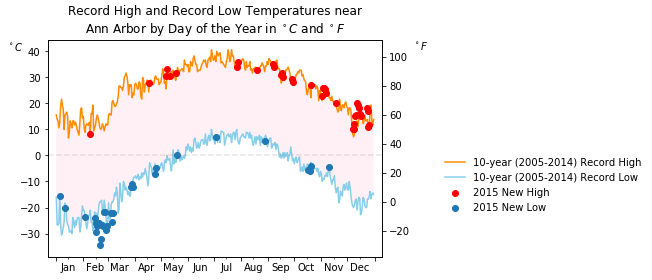

In [5]:
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter


plt.figure()

observation_dates = np.arange('2015-01-01', '2016-01-01', dtype = 'datetime64[D]')

################## Plot the 2005-2014 data ##################
# Must use date object as x variable.
plt.plot(observation_dates, pivot_base['TMAX'], c = 'darkorange', zorder = 1, 
         label = '10-year (2005-2014) Record High')
plt.plot(observation_dates, pivot_base['TMIN'], c = 'skyblue', zorder = 1,
         label = '10-year (2005-2014) Record Low')

# Shade the area between the area between the record high and record low temperatures.
ax = plt.gca()
ax.fill_between(x = observation_dates, 
                y1 = pivot_base['TMIN'], y2 = pivot_base['TMAX'], 
                facecolor = 'lavenderblush')

# Add the 0 degree celsius line.
plt.axhline(linestyle = '--', color = 'gray', linewidth = 0.3) 

################## Add the 2015 extreme data ##################
plt.scatter(observation_dates, pivot_2015.TMAX.where(pivot_2015.TMAX_extreme == True), 
            label = '2015 New High', c = 'r', zorder = 2)
plt.scatter(observation_dates, pivot_2015.TMIN.where(pivot_2015.TMIN_extreme == True), 
            label = '2015 New Low', zorder = 2)


################## Deal with the legend, axis, title, etc. ##################
plt.legend(bbox_to_anchor = (1.8, 0.5), frameon = False)
plt.title('Record High and Record Low Temperatures near\nAnn Arbor by Day of the Year in $^\circ C$ and $^\circ F$')

# Increase the left and right margin to better show the edge points.
ax.set_xlim(observation_dates[0] - 10, observation_dates[364] + 10)

# Set major x ticks at the beginning/end of each month and add minor ticks at the 
# 15th day of each month.
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_minor_locator(MonthLocator(bymonthday = 15))

# Put the abbr. month labels in the middle of of the span of each month.
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%b'))

# Set a second y-axis with Fahrenheit degree.
mn_c, mx_c = ax.get_ylim()
mn_f = mn_c * 1.8 + 32
mx_f = mx_c * 1.8 + 32
ax2 = ax.twinx()
ax2.set_ylim(mn_f, mx_f)

# Set labels for the y axes.
ax.set_ylabel('$^\circ C$', rotation = 0, position = (0, 0.94))
ax2.set_ylabel('$^\circ F$', rotation = 0, labelpad = 10, position = (0, 1))

# Turn the y-axis ticks outward.
ax.tick_params(axis = 'y', direction = 'out')
ax2.tick_params(axis = 'y', direction = 'out')

# Use argument bbox_inches = 'tight' to include the legend.
plt.savefig('NOAA_Image_Feng.pdf', bbox_inches = 'tight')

plt.show()


#### Describe how your visual leverages the guidelines of effective visual design outlined in module one of this course (e.g., beauty, truthfulness, functionality, and insightfulness).

* Beauty: I use warm colors for the record high temperatures and cold colors for record lows. Shaded area is in a neutral color.    
* Functionality: Both Celsius and Fahrenheit degrees are displayed. All the tick marks (y-axis tick marks outward) are kept intentionally for easy pinpointing. Left and right margins are created for a clearer view.                      
* Truthfulness: There's no lie factors.           
* Insightfulness: With the lines and shaded area as background, it's easy to spot the days in 2015 that had extreme temperatures.

